In [47]:
import pyrtl
from pyrtl import CompiledSimulation, reset_working_block
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from hardware_accelerators import *
from hardware_accelerators.simulation.compile import (
    ReusableCompiledSimulation,
    CompiledAccelerator,
)
from hardware_accelerators.simulation.accelerator import CompiledAcceleratorSimulator
from hardware_accelerators.rtllib.accelerator import CompiledAcceleratorConfig
from hardware_accelerators.nn import load_model, MLP

## Test loading from saved sim


In [2]:
# Data transformation: convert images to tensor and normalize them
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
# Download MNIST test data
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


def get_batch(batch_size):
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    batch, labels = next(iter(loader))
    return batch.reshape(batch_size, -1).numpy(), labels.numpy()


def get_activation():
    image, _ = next(iter(test_loader))
    image = image.detach().numpy().reshape(-1)
    return image

In [ ]:
CHUNK_SIZE = 8

config_w8a16 = CompiledAcceleratorConfig(
    array_size=CHUNK_SIZE,
    activation_type=BF16,
    weight_type=Float8,
    multiplier=float_multiplier,
)
config_w8a16 = CompiledAcceleratorConfig(
    array_size=CHUNK_SIZE,
    activation_type=BF16,
    weight_type=Float8,
    multiplier=float_multiplier,
)
config_w16a16 = CompiledAcceleratorConfig(
    array_size=CHUNK_SIZE,
    activation_type=BF16,
    weight_type=BF16,
    multiplier=float_multiplier,
)

In [51]:
reset_working_block()

In [ ]:
model = load_model("models/mlp_mnist.pth")
sim_w8a16 = CompiledAcceleratorSimulator(config_w8a16, model=model)
sim_w16a16 = CompiledAcceleratorSimulator(config_w16a16, model=model)

Using precompiled library: /Users/kaibreese/UCSD/dsc180b/hardware-accelerators/hardware_accelerators/bin/w8ab16s8/pyrtlsim.so
Using precompiled library: /Users/kaibreese/UCSD/dsc180b/hardware-accelerators/hardware_accelerators/bin/wb16ab16s8/pyrtlsim.so


In [55]:
pyrtl.set_debug_mode(False)

In [ ]:
from hardware_accelerators.rtllib.multipliers import float_multiplier_simple

reset_working_block()

config_w8a32 = CompiledAcceleratorConfig(
    array_size=8,
    activation_type=Float32,
    weight_type=Float8,
    multiplier=float_multiplier_simple,
)

sim_w8a32 = CompiledAcceleratorSimulator(config_w8a32, model=model, recompile=True)

Constructing hardware for config w8a32s8...


(7, 10)

_     ._   __/__   _ _  _  _ _/_   Recorded: 01:29:32  Samples:  7407
 /_//_/// /_\ / //_// / //_'/ //     Duration: 8.082     CPU time: 7.946
/   _/                      v5.0.1

Cell [65]

8.081 <module>  /var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_97428/2218646223.py:1
`- 8.081 CompiledAcceleratorSimulator.predict  hardware_accelerators/simulation/accelerator.py:761
   `- 8.061 CompiledAcceleratorSimulator.execute_instruction  hardware_accelerators/simulation/accelerator.py:694
      `- 8.026 CompiledAcceleratorSimulator._step  hardware_accelerators/simulation/accelerator.py:660
         `- 7.888 ReusableCompiledSimulation.step  pyrtl/compilesim.py:156
               [7 frames hidden]  pyrtl, <frozen abc>
                  7.874 ReusableCompiledSimulation.run  pyrtl/compilesim.py:304
                  `- 6.874 [self]  pyrtl/compilesim.py
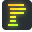

In [65]:
%%pyinstrument

pred = sim_w8a16.predict(get_activation())
np.argmax(pred).item(), len(pred)

In [60]:
batch, labels = get_batch(10)

results = sim_w8a32.predict_batch(batch)
preds = np.argmax(results, axis=1)

print()
print(preds)
print(labels)
print(preds == labels)

Completed 1584/1618 tiles
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]
[ True  True  True  True  True  True  True  True  True  True]


In [33]:
pred = sim_w8a16.predict(get_activation())
np.argmax(pred).item(), len(pred)

(7, 10)

In [32]:
pred = sim_w16a16.predict(get_activation())
np.argmax(pred).item(), len(pred)

(7, 10)

In [34]:
batch, labels = get_batch(10)

results = sim_w8a16.predict_batch(batch)
preds = np.argmax(results, axis=1)

print()
print(preds)
print(labels)
print(preds == labels)

Completed 1584/1618 tiles
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]
[ True  True  True  True  True  True  True  True  True  True]


In [28]:
batch, labels = get_batch(10)

results = sim_fp8.predict_batch(batch)
preds = np.argmax(results, axis=1)

print()
print(preds)
print(labels)
print(preds == labels)

Completed 1584/1618 tiles
[7 0 7 0 3 0 2 0 9 0]
[7 2 1 0 4 1 4 9 5 9]
[ True False False  True False False False False False False]


In [ ]:
print(sim_bf16.config)

CompiledAcceleratorConfig(
        array_size: 8
        activation_type: BF16
        weight_type: BF16
        multiplier: IEEE 754
        accum_addr_width: 12
        pipeline: False
        name: wb16ab16s8
    )


In [79]:
def get_batch(batch_size):
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    batch, labels = next(iter(loader))
    return batch.reshape(batch_size, -1).numpy(), labels


batch, labels = get_batch(10)
preds == labels

tensor([True, True, True, True, True, True, True, True, True, True])

In [106]:
isinstance(model, torch.nn.Module)

True

In [84]:
torch.tensor(results, dtype=torch.bfloat16)

tensor([[7.4215e-09, 7.4465e-12, 4.8801e-07, 6.7055e-06, 3.6637e-14, 3.8199e-10,
         9.2704e-15, 1.0000e+00, 1.1350e-09, 4.7730e-08],
        [1.3853e-08, 3.4332e-05, 1.0000e+00, 1.1176e-06, 4.6629e-15, 1.6917e-10,
         3.8417e-09, 4.4587e-13, 9.1735e-08, 2.2471e-13],
        [1.8394e-08, 1.0000e+00, 1.3351e-03, 6.3896e-05, 6.5804e-05, 4.1246e-05,
         2.9951e-06, 2.9206e-05, 7.4863e-05, 8.3074e-07],
        [1.0000e+00, 1.1539e-11, 3.4051e-09, 7.5033e-11, 2.0140e-08, 3.4226e-08,
         2.2352e-07, 2.0373e-10, 4.6020e-10, 3.5912e-06],
        [1.5061e-09, 7.0486e-11, 6.4261e-08, 5.4797e-11, 1.0000e+00, 6.1933e-08,
         1.7812e-08, 5.1036e-07, 4.2201e-09, 5.3406e-04],
        [1.6080e-09, 1.0000e+00, 1.0967e-05, 3.5018e-06, 1.8954e-05, 7.1886e-09,
         4.3656e-09, 3.2425e-05, 1.0058e-06, 4.1444e-08],
        [7.7716e-14, 2.7753e-07, 3.8445e-06, 1.5497e-06, 1.0000e+00, 1.3828e-05,
         2.0838e-08, 5.8711e-06, 8.8120e-04, 1.2207e-04],
        [9.5952e-11, 3.7812

In [92]:
np.sum(results, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
from torch.nn import CrossEntropyLoss

CrossEntropyLoss()(torch.tensor(results), labels)

1.4622700768294972

In [108]:
type(test_dataset)

torchvision.datasets.mnist.MNIST

In [ ]:
# Evaluation function
def evaluate(
    sim: CompiledAcceleratorSimulator,
    model: MLP,
    dataset,
    batch_size,
    criterion=CrossEntropyLoss(),
):
    correct = 0
    total = 0
    running_loss = 0.0
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch, labels in data_loader:
        batch = batch.reshape(batch_size, -1).numpy()
        outputs = sim.predict_batch(model, batch)
        loss = criterion(torch.tensor(outputs), labels)
        running_loss += loss.item()

        # Get predictions from the maximum value
        predicted = np.argmax(outputs, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break
    avg_loss = running_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


evaluate(sim_bf16, model, test_dataset, 10)

[array([[0.      , 0.      , 3.109375, 0.      ],
       [0.      , 9.9375  , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 8.0625  , 3.6875  , 3.078125],
       [0.      , 7.625   , 0.546875, 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 2.609375, 1.15625 , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 9.5625  , 0.      , 0.      ],
       [0.      , 7.375   , 0.      , 3.78125 ]]), array([[ 0.      ,  6.8125  ,  6.625   ,  0.      ],
       [ 1.9375  ,  0.      ,  0.      ,  4.9375  ],
       [ 0.      ,  0.      ,  0.      ,  6.8125  ],
       [ 0.      ,  0.      ,  6.9375  ,  0.      ],
       [ 0.      ,  5.3125  , 11.8125  ,  0.      ],
       [ 0.      ,  1.6875  ,  0.      ,  6.0625  ],
       [ 0.      ,  1.078125,  8.5625  ,  0.      ],
       [ 0.      ,  3.96875 ,  3.96875 ,  4.0625  ],
       [ 0.      ,  0.      , 10.6875  ,  0.      ],
       [ 0.      ,  7.6875  , 

(0.001462270076829497, 100.0)

In [ ]:
from hardware_accelerators.simulation.matrix_utils import bias_trick


weights_1 = model.fc1.weight.numpy(force=True)
bias_1 = model.fc1.bias.numpy(force=True)
weights_2 = model.fc2.weight.numpy(force=True)
bias_2 = model.fc2.bias.numpy(force=True)

# Apply the bias trick
W1_aug = bias_trick(weights_1, bias_1)
W2_aug = bias_trick(weights_2, bias_2)

W1_aug.shape[0]

128

In [ ]:
10000 / 10

1000.0

# Compiling all configurations


In [ ]:
from typing import Iterator, Type, List, Callable
from itertools import product

from hardware_accelerators.dtypes import *


def generate_accelerator_configs(
    array_size: int = 16,
    dtypes: List[Type[BaseFloat]] = None,
    multipliers: List[Callable] = None,
) -> Iterator[CompiledAcceleratorConfig]:
    """
    Generate all valid CompiledAcceleratorConfig combinations.

    Args:
        array_size: Size of the systolic array
        dtypes: List of data types to consider. Defaults to [Float8, BF16, FP16, FP32]
        multipliers: List of multiplier functions. Defaults to [float_multiplier, lmul]

    Yields:
        Valid CompiledAcceleratorConfig objects

    Restrictions:
        1. The activation_type must be greater than or equal to the weight_type in terms of bitwidth.
        2. 16-bit float types (BF16, FP16) should not be combined with each other.
           They should only pair with themselves or with FP32.
    """
    if dtypes is None:
        dtypes = [Float8, BF16, Float16, Float32]

    if multipliers is None:
        multipliers = [float_multiplier, lmul_fast]

    # Sort dtypes by bitwidth for easier comparison
    dtype_bitwidths = {dtype: dtype.bitwidth() for dtype in dtypes}
    sorted_dtypes = sorted(dtypes, key=lambda d: dtype_bitwidths[d])

    # Identify 16-bit float types
    bit16_float_types = [dtype for dtype in dtypes if dtype_bitwidths[dtype] == 16]

    # Generate all combinations
    for multiplier in multipliers:
        for weight_type in sorted_dtypes:
            # Find valid activation types based on bitwidth
            valid_activation_types = [
                dtype
                for dtype in sorted_dtypes
                if dtype_bitwidths[dtype] >= dtype_bitwidths[weight_type]
            ]

            for activation_type in valid_activation_types:
                # Skip invalid combinations of 16-bit float types
                if (
                    weight_type in bit16_float_types
                    and activation_type in bit16_float_types
                    and weight_type != activation_type
                ):
                    continue

                yield CompiledAcceleratorConfig(
                    array_size=array_size,
                    activation_type=activation_type,
                    weight_type=weight_type,
                    multiplier=multiplier,
                )


# Example usage:
def print_all_configs():
    for i, config in enumerate(generate_accelerator_configs()):
        print(f"Config {i+1}:")
        print(f"  Array Size: {config.array_size}")
        print(f"  Activation Type: {config.activation_type.__name__}")
        print(f"  Weight Type: {config.weight_type.__name__}")
        print(f"  Multiplier: {config.multiplier.__name__}")
        print()

In [32]:
print_all_configs()

Config 1:
  Array Size: 16
  Activation Type: Float8
  Weight Type: Float8
  Multiplier: float_multiplier

Config 2:
  Array Size: 16
  Activation Type: BF16
  Weight Type: Float8
  Multiplier: float_multiplier

Config 3:
  Array Size: 16
  Activation Type: Float16
  Weight Type: Float8
  Multiplier: float_multiplier

Config 4:
  Array Size: 16
  Activation Type: Float32
  Weight Type: Float8
  Multiplier: float_multiplier

Config 5:
  Array Size: 16
  Activation Type: BF16
  Weight Type: BF16
  Multiplier: float_multiplier

Config 6:
  Array Size: 16
  Activation Type: Float32
  Weight Type: BF16
  Multiplier: float_multiplier

Config 7:
  Array Size: 16
  Activation Type: Float16
  Weight Type: Float16
  Multiplier: float_multiplier

Config 8:
  Array Size: 16
  Activation Type: Float32
  Weight Type: Float16
  Multiplier: float_multiplier

Config 9:
  Array Size: 16
  Activation Type: Float32
  Weight Type: Float32
  Multiplier: float_multiplier

Config 10:
  Array Size: 16
  Activa